In [8]:
import boa
import matplotlib.pyplot as plt
from utils import deploy_infra, deploy_pool

## **Table of Content**

1. [Infrastrucutre and Pool Setup](#infrastrucutre-and-pool-setup)
2. [Ramping A and Gamma](#2-ramping-a-and-gamma)
3. [Stop Ramping A and Gamma](#3-stop-ramping-a-and-gamma)
4. [Applying New Parameters](#4-applying-new-parameters)

### **1. Infrastrucutre and Pool Setup**

Before we can exchange tokens, we need to deploy the twocrypto-ng infrastructure and deploy a pool. Afterwards, we grant approval to the pool.

In [9]:
# deploying infra for twocrypto-ng pools
infra = deploy_infra()
factory = infra["factory"]
admin = infra["admin"]
coin_a = infra["coin_a"]
coin_b = infra["coin_b"]

# deploy pool
pool = deploy_pool(factory, coin_a, coin_b)
pool = infra["impl"].at(pool)
pool

<../contracts/main/CurveTwocryptoOptimized.vy at 0x89007e2D2dc2CF3C1BeaeD73648f9b6EC6B4aCff, compiled with vyper-0.3.10+9136169>
<storage: cached_price_scale=1000000000000000000, cached_price_oracle=1000000000000000000, cached_xcp_oracle=0, last_prices=1000000000000000000, last_timestamp=580992689520163979679196662001133189288159386877, last_xcp=0, xcp_ma_time=62324, initial_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma_time=0, balances=[0, 0], D=0, xcp_profit=0, xcp_profit_a=1000000000000000000, virtual_price=0, packed_rebalancing_params=680564733841876929619973849625130958848000000000865, packed_fee_params=8847341539944400050877843276543133320576000000, last_admin_fee_claim_timestamp=0, admin_lp_virtual_balance=0, balanceOf={}, allowance={}, totalSupply=0, nonces={}>

### **2. Ramping A and Gamma**

A and gamma values can only be ramped by the `admin` of the Factory.


- #### `ramp_A_gamma(future_A: uint256, future_gamma: uint256, future_time: uint256):`

    Function to linearly ramp the values of `A` and `gamma`. Both `A` and `gamma` are packed within the same variable.

    Emits: `RampAgamma`

    | Input          | Type      | Description           |
    | -------------- | --------- | --------------------- |
    | `future_A`     | `uint256` | Future value of `A`   |
    | `future_gamma` | `uint256` | Future value of `gamma` |
    | `future_time`  | `uint256` | Timestamp at which the ramping will end |


    When ramping A/gamma, `future_A` and `future_gamma` values are packed and stored into a single uint256 variable (`future_A_gamma`).

In [10]:
# ts = current timestamp
ts = boa.env.vm.patch.timestamp


# unpack `future_A_gamma()`. These values are the current A/gamma values as we did not call `ramp_A_gamma` yet.
print("raw future_A_gamma: " + str(pool.future_A_gamma()))
print("A (unpacked): " + str(pool.future_A_gamma() >> 128))
print("gamma (unpacked): " + str(pool.future_A_gamma() & (2**128 -1)))
print("current timestamp: " + str(ts))
print("---------------")

# now we ramp up A and gamma and unpack `future_A_gamma()` again. as we can see, the values sucessfully changed. We can also query `future_A_gamma_time` to get the timestamp when ramping is finished.
with boa.env.prank(admin):
    pool.ramp_A_gamma(1200000, 200000000000000, ts + 86400)

print("raw future_A_gamma: " + str(pool.future_A_gamma()))
print("A (unpacked): " + str(pool.future_A_gamma() >> 128))
print("gamma (unpacked): " + str(pool.future_A_gamma() & (2**128 -1)))
print("ramp finished: " + str(pool.future_A_gamma_time()))

A = []
gamma = []
timestamps = [] 

# increment timestamps by 2500 and save new A and gamma value in a dict
for current_time in range(ts, ts + 95000, 2500):
    A.append(pool.A())
    gamma.append(pool.gamma())
    timestamps.append(current_time)
    boa.env.time_travel(2500)

raw future_A_gamma: 136112946768375385385349842972852284582400000
A (unpacked): 400000
gamma (unpacked): 145000000000000
current timestamp: 1707384061
---------------
raw future_A_gamma: 408338840305126156156049528918321853747200000
A (unpacked): 1200000
gamma (unpacked): 200000000000000
ramp finished: 1707470461


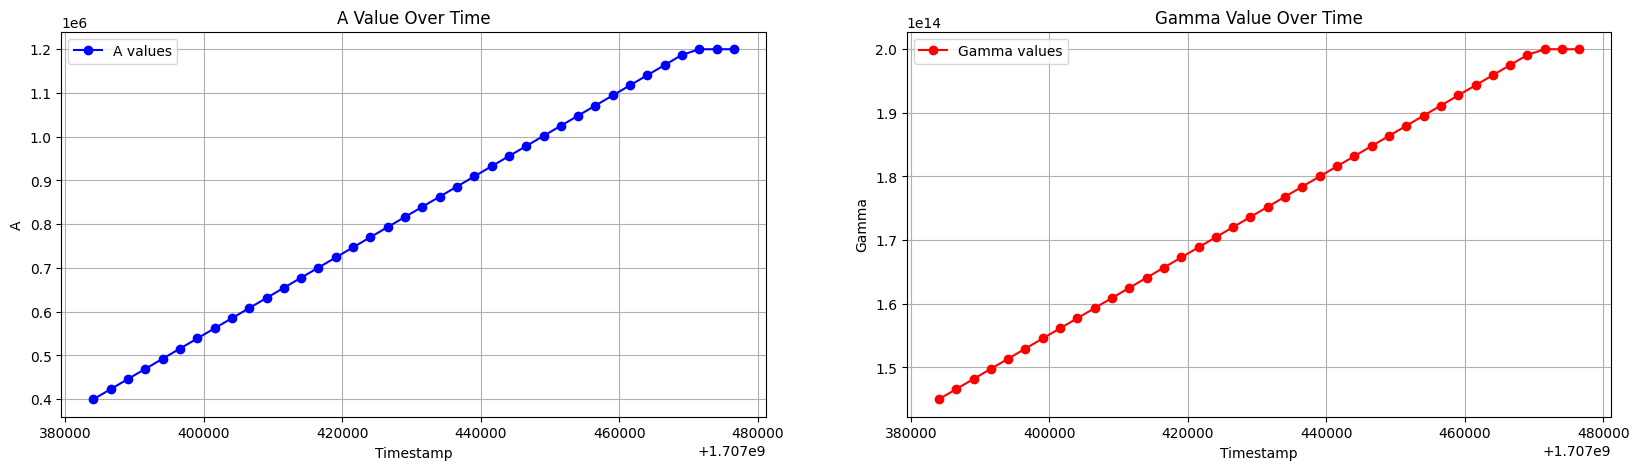

In [11]:
plt.figure(figsize=(20, 5))

# Subplot for A values
plt.subplot(1, 2, 1)
plt.plot(timestamps, A, label='A values', color='blue', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('A')
plt.title('A Value Over Time')
plt.legend()
plt.grid(True)

# Subplot for gamma values
plt.subplot(1, 2, 2)
plt.plot(timestamps, gamma, label='Gamma values', color='red', marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Gamma')
plt.title('Gamma Value Over Time')
plt.legend()
plt.grid(True)

plt.show()


### **3. Stop Ramping A and Gamma**

- #### `stop_ramp_A_gamma():`
    Function to immediately stop the ramping of A and gamma parameters and set them to their current values.

    Emits: `StopRampA`

The `admin` can stop the current ramping of the parameters via the `stop_ramp_A_gamma` function. To test this, lets ramp A and gamma again:

In [12]:
ts = boa.env.vm.patch.timestamp

print("before ramp: " + str(pool.A()))
print("before ramp: " + str(pool.gamma()))
print("----------")

# ramp A and gamma again
with boa.env.prank(admin):
    pool.ramp_A_gamma(1600000, 400000000000000, ts + 86400)

# now we time travel 40000 seconds (50% of the ramp time) and check the values to make sure its actually ramping up:
boa.env.time_travel(40000)
print("while ramp: " + str(pool.A()))
print("while ramp: " + str(pool.gamma()))
print("----------")

# stop the ramping
with boa.env.prank(admin):
    pool.stop_ramp_A_gamma()


# time travel again to check if the ramping has stopped
boa.env.time_travel(43200)
print("after stop: " + str(pool.A()))
print("after stop: " + str(pool.gamma()))

before ramp: 1200000
before ramp: 200000000000000
----------
while ramp: 1385185
while ramp: 292592592592592
----------
after stop: 1385185
after stop: 292592592592592


### **4. Applying New Parameters**

New parameter can only be changed by the `admin` of the Factory.

- #### `apply_new_parameters(_new_mid_fee: uint256, _new_out_fee: uint256, _new_fee_gamma: uint256, _new_allowed_extra_profit: uint256, _new_adjustment_step: uint256, _new_ma_time: uint256, _new_xcp_ma_time: uint256):`"

    Function to commit new parameters. The new parameters are applied immediately.

    Emits: `NewParameters`

    | Input                   | Type      | Description                                         |
    | ----------------------- | --------- | --------------------------------------------------- |
    | `_new_mid_fee`          | `uint256` | New `mid_fee` value.                                |
    | `_new_out_fee`          | `uint256` | New `out_fee` value.                                |
    | `_new_fee_gamma`        | `uint256` | New `fee_gamma` value.                              |
    | `_new_allowed_extra_profit` | `uint256` | New `allowed_extra_profit` value.               |
    | `_new_adjustment_step`  | `uint256` | New `adjustment_step` value.                        |
    | `_new_ma_time`          | `uint256` | New `ma_time` value, which is time_in_seconds/ln(2).|
    | `_new_xcp_ma_time`      | `uint256` | New ma time for xcp oracles.                        |

In [13]:
print(
    "BEFORE APPLYING NEW PARAMETERS" + "\n" +
    "mid_fee: " + str(pool.mid_fee()) + "\n" +
    "out_fee: " + str(pool.out_fee()) + "\n" +
    "fee_gamma: " + str(pool.fee_gamma()) + "\n" +
    "allowed_extra_profit: " + str(pool.allowed_extra_profit()) + "\n" +
    "adjustment_step: " + str(pool.adjustment_step()) + "\n" +
    "ma_time: " + str(pool.ma_time()) + "\n" +
    "xcp_ma_time: " + str(pool.xcp_ma_time())
)

print("------------------------")

with boa.env.prank(admin):
    pool.apply_new_parameters(
        30000000, # _new_mid_fee
        45000000, # _new_out_fee
        300000000000000, # _new_fee_gamma
        3000000000000, # _new_allowed_extra_profit
        170000000000000, # _new_adjustment_step
        865, # _new_ma_time
        1800 * 24, # _new_xcp_ma_time
    )

print(
    "AFTER APPLYING NEW PARAMETERS:" + "\n" +
    "mid_fee: " + str(pool.mid_fee()) + "\n" +
    "out_fee: " + str(pool.out_fee()) + "\n" +
    "fee_gamma: " + str(pool.fee_gamma()) + "\n" +
    "allowed_extra_profit: " + str(pool.allowed_extra_profit()) + "\n" +
    "adjustment_step: " + str(pool.adjustment_step()) + "\n" +
    "ma_time: " + str(pool.ma_time()) + "\n" +
    "xcp_ma_time: " + str(pool.xcp_ma_time()),
)

BEFORE APPLYING NEW PARAMETERS
mid_fee: 26000000
out_fee: 45000000
fee_gamma: 230000000000000
allowed_extra_profit: 2000000000000
adjustment_step: 146000000000000
ma_time: 600
xcp_ma_time: 62324
------------------------
AFTER APPLYING NEW PARAMETERS:
mid_fee: 30000000
out_fee: 45000000
fee_gamma: 300000000000000
allowed_extra_profit: 3000000000000
adjustment_step: 170000000000000
ma_time: 600
xcp_ma_time: 43200
